<a href="https://colab.research.google.com/github/beckerfelipee/CNN-ImageClassification/blob/main/imageClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Download Zip file of cats and dogs dataset
!wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

In [ ]:
# Unzip the file
!unzip cats_and_dogs_filtered.zip

In [3]:
# Remove zip file
!rm -rf cats_and_dogs_filtered.zip

In [ ]:
!pip install tensorflow

In [5]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf

In [6]:
# Find the dataset directory
dataset_dir = os.path.join(os.getcwd(), 'cats_and_dogs_filtered')

dataset_train_dir = os.path.join(dataset_dir, 'train')
dataset_train_cats_len = len(os.listdir(os.path.join(dataset_train_dir, 'cats')))
dataset_train_dogs_len = len(os.listdir(os.path.join(dataset_train_dir, 'dogs')))

dataset_validation_dir = os.path.join(dataset_dir, 'validation')
dataset_validation_cats_len = len(os.listdir(os.path.join(dataset_validation_dir, 'cats')))
dataset_validation_dogs_len = len(os.listdir(os.path.join(dataset_validation_dir, 'dogs')))

print(f'Train Cats: {dataset_train_cats_len}')
print(f'Train Dogs: {dataset_train_dogs_len}')
print(f'Validation Cats: {dataset_validation_cats_len}')
print(f'Validation Dogs: {dataset_validation_dogs_len}')

Train Cats: 1000
Train Dogs: 1000
Validation Cats: 500
Validation Dogs: 500


**We need to adjust input settings.**

Size: Let's set the size of all images to 160x160 pixels.

Image color channels.

In [7]:
image_width = 160
image_height = 160
image_color_channel = 3
image_color_channel_size = 255
image_size = (image_width, image_height)
image_shape = image_size + (image_color_channel,)

In [8]:
batch_size = 32  # Number of features to bring at a time from my dataset
epochs = 20  # Number of times I will iterate through my entire dataset
learning_rate = 0.0001  # Learning rate

class_names = ['cat', 'dog']  # Output values

Keras - high-level API library for building, training, and evaluating deep neural networks.

In [9]:
dataset_train = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_train_dir,
    image_size = image_size,
    batch_size = batch_size,
    shuffle = True
)

Found 2000 files belonging to 2 classes.


In [10]:
dataset_validation = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_validation_dir,
    image_size = image_size,
    batch_size = batch_size,
    shuffle = True
)

Found 1000 files belonging to 2 classes.


Create a third test dataset from a portion of the validation dataset.

In [11]:
dataset_validation_cardinality = tf.data.experimental.cardinality(dataset_validation)

# Define the proportion of the validation dataset to be used as test dataset (1/5)
dataset_validation_batches = dataset_validation_cardinality // 5
dataset_test = dataset_validation.take(dataset_validation_batches)

# Update the validation dataset by skipping the portion that went to the test dataset
dataset_validation = dataset_validation.skip(dataset_validation_batches)

print(f'Validation Dataset Cardinality: {tf.data.experimental.cardinality(dataset_validation)}')
print(f'Test Dataset Cardinality: {tf.data.experimental.cardinality(dataset_test)}')

Validation Dataset Cardinality: 26
Test Dataset Cardinality: 6



**What's the difference between the datasets?**

- Training

Actively updating the parameters of the neural network.

- Validation

Validating the model during training (does not modify parameters).

- Test

Testing the model after training.



In [12]:
# plotar algumas imagens dos datasets

def plot_dataset(dataset):
    plt.gcf().clear()
    plt.figure(figsize = (15, 15))

    for features, labels in dataset.take(1):
        for i in range(9):
            plt.subplot(3, 3, i + 1)
            plt.axis('off')

            plt.imshow(features[i].numpy().astype('uint8'))
            plt.title(class_names[labels[i]])

<Figure size 640x480 with 0 Axes>

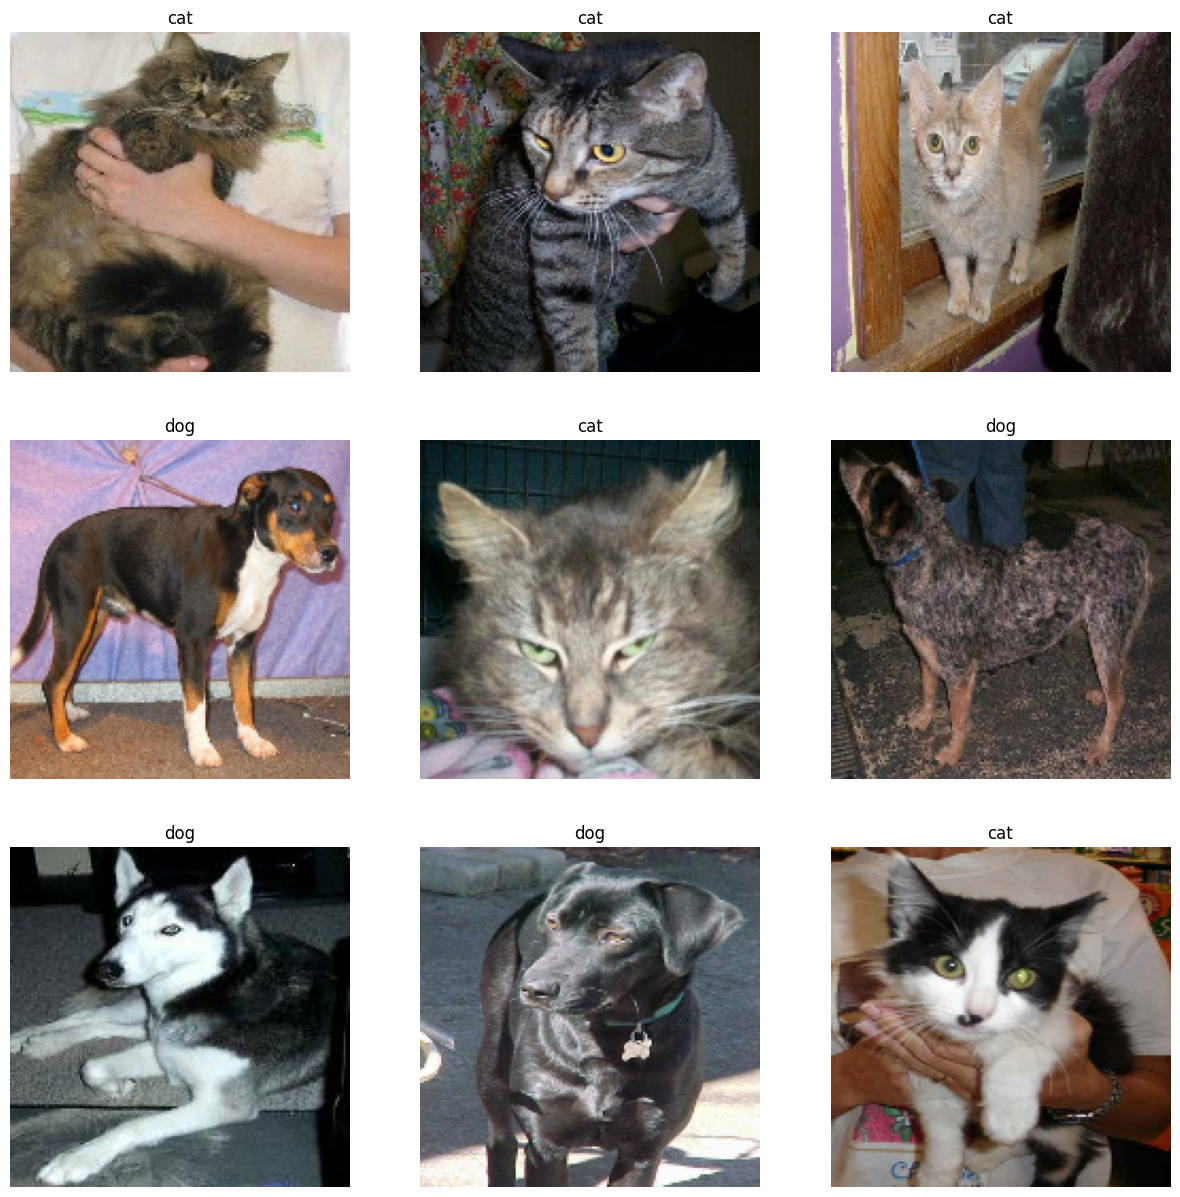

In [13]:
plot_dataset(dataset_train)

<Figure size 640x480 with 0 Axes>

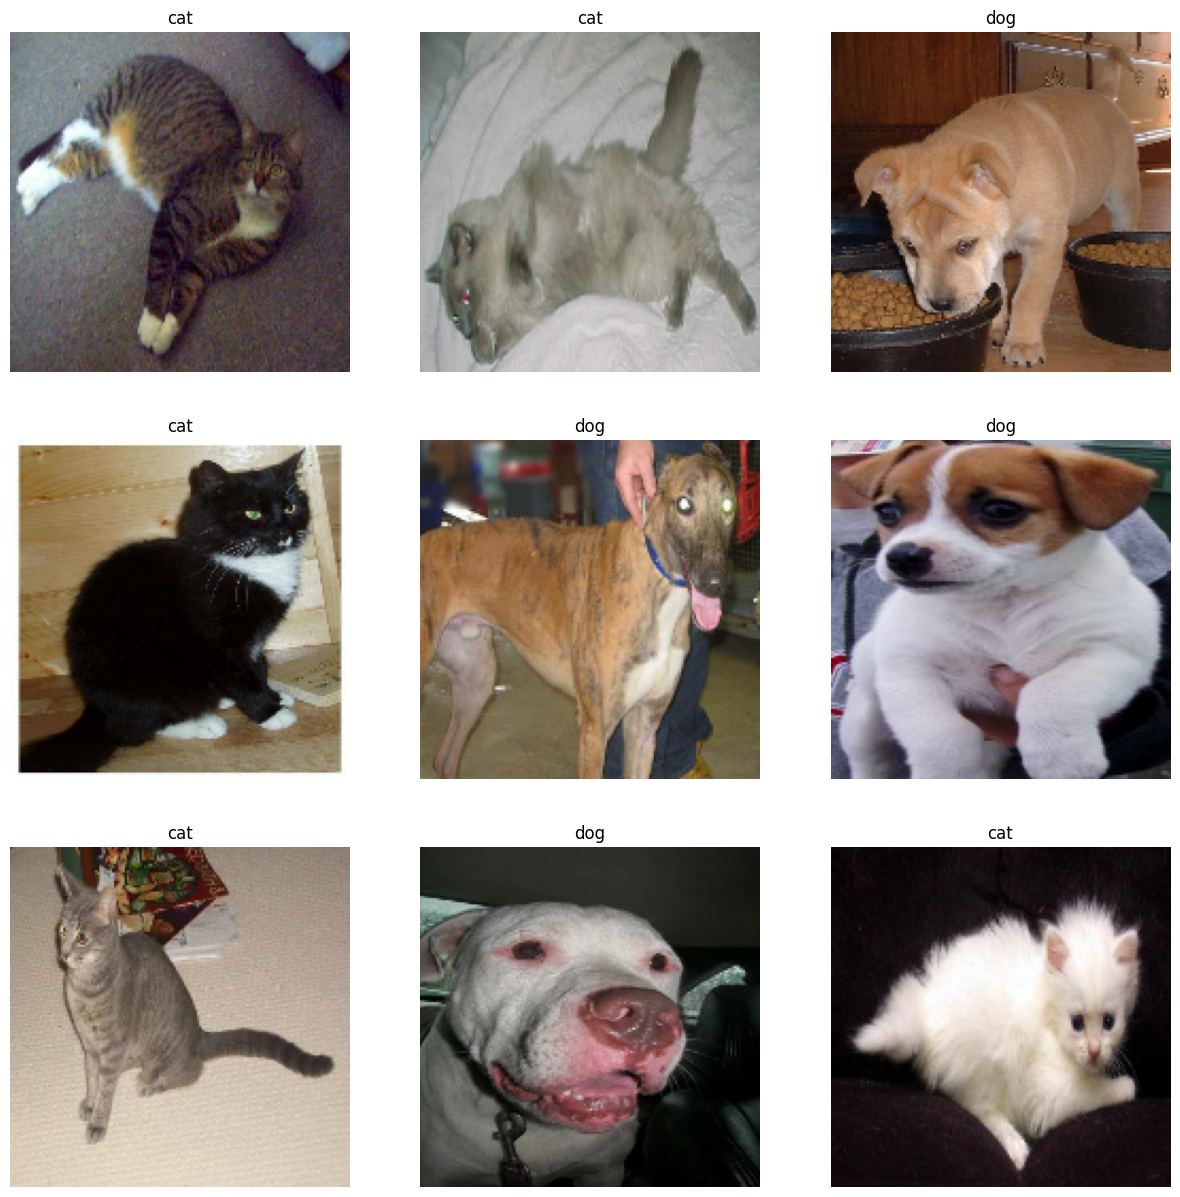

In [14]:
plot_dataset(dataset_validation)

<Figure size 640x480 with 0 Axes>

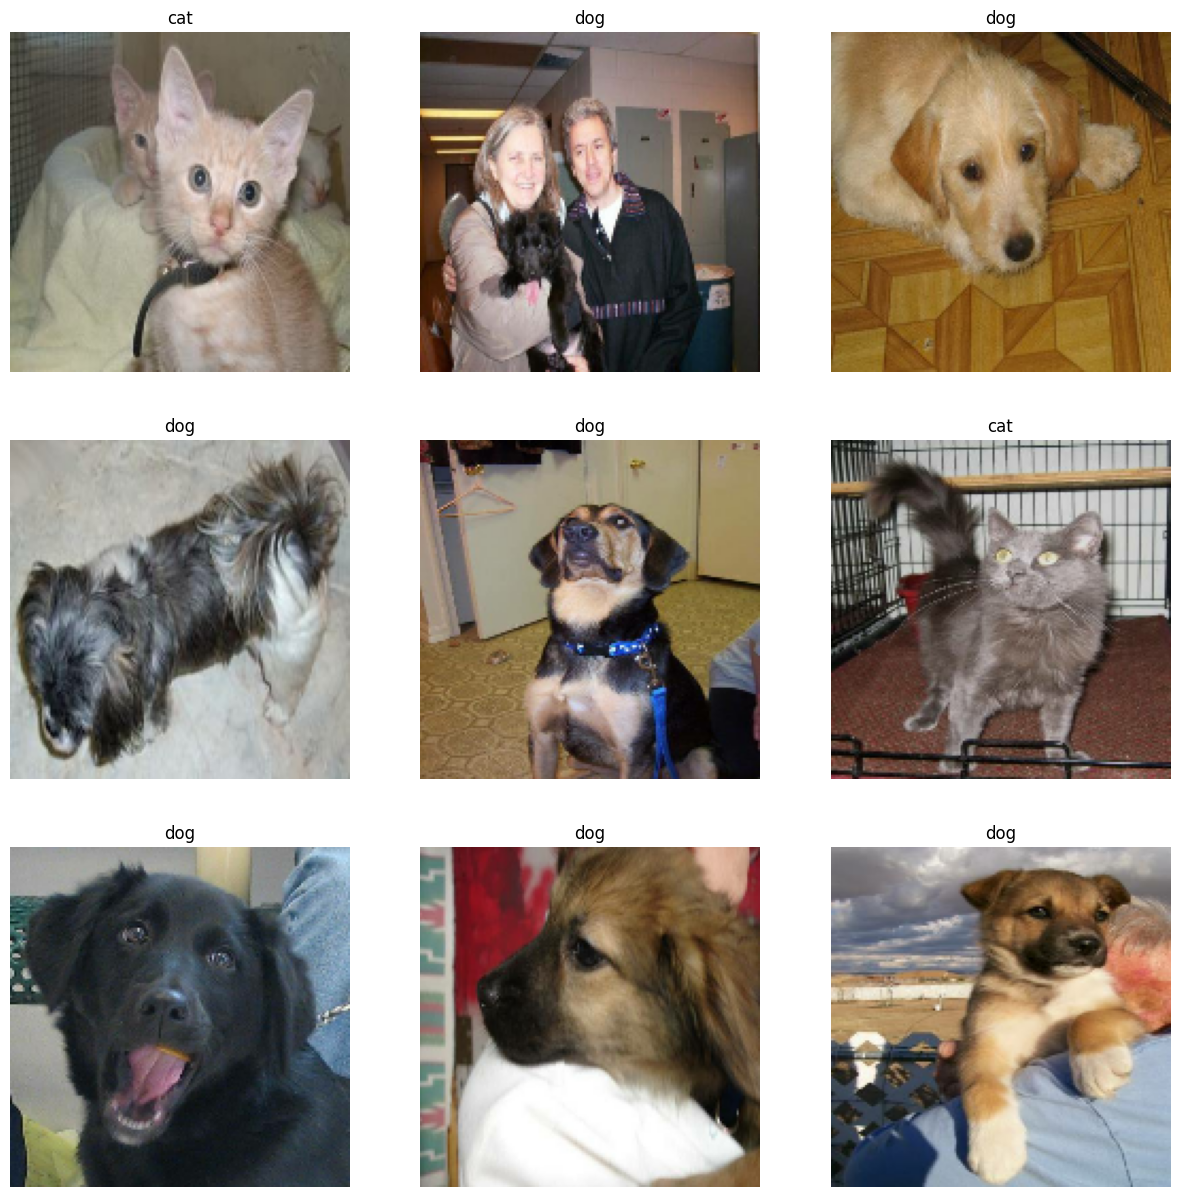

In [15]:
plot_dataset(dataset_test)

Create the model - Convolutional Neural Network

Our feature is a 160 by 160 matrix whose value is not a number but rather a vector of size 3, representing the color.

A kernel acts as a filter and passes over the feature matrix, generating a response based on simple multiplication.

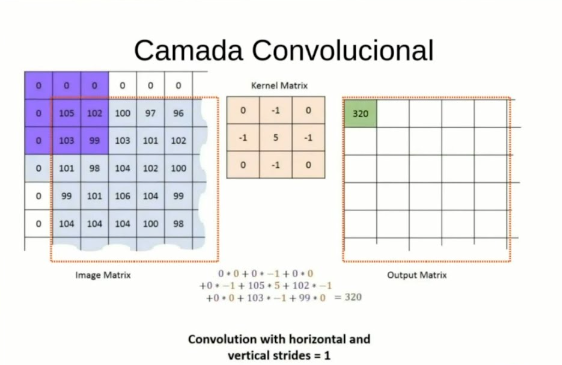

If I were to use multiple kernels, it would generate a map at the output, called an activation map. Thus, it would be necessary to employ a second algorithm to consolidate this activation map.

**Create the neural network**

Fully customizable

In [16]:
model = tf.keras.models.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(
        1. / image_color_channel_size, # values normalization
        input_shape = image_shape
    ),
    tf.keras.layers.Conv2D(16, 3, padding = 'same', activation = 'relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, padding = 'same', activation = 'relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, padding = 'same', activation = 'relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

**Create the neural network**

Sequential: One layer is applied after another in sequence.

The first layer will rescale the images to the format 160x160x3.

Normalization: Instead of color values ranging from 0-255, I want them to range from 0-1.

The second layer is a convolutional layer with a size of 16 (the kernel will pass 16 times), with a kernel size of 3 (3x3). Padding = 'same' is used to add zeros around the filter, which serves to emphasize the peripheral values of the matrix. The activation function used is 'relu': Rectified Linear Unit.

About ReLU:

It returns 0 if the input value is negative and returns the input value itself if it is positive. This means that the function is linear for positive values and zeroes for negative values.

The third layer is MaxPooling, which serves to consolidate the activation map from the previous convolutional layer.

The process is repeated in the following layers, increasing the size of the layer (number of parameters/features applied).

The Flatten layer is responsible for applying an algorithm that will compress all this.

The first Dense layer has 128 nodes whose values will be updated during training, and the relu activation function will also be applied at the output.

The next Dense layer has 1 node, meaning only one value at the output. With the sigmoid activation function. A function that, regardless of the value sent, will always return a value between 0 and 1. Since relu functions were used, the possible values will always be positive. So sigmoid can only deliver two values: 0 for cat and 1 for dog.

In [17]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = ['accuracy']
)

Two steps performed during the training of a neural network

**Feedforward**

When the model is fed with an example and for a certain feature, we expect a certain label.

**Backpropagation**

When the error of this output is calculated and this value is used to update the parameters of the neural network.

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 160, 160, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 160, 160, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 80, 80, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 80, 80, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 40, 40, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 40, 40, 64)        1

Train the model - Approximately 20 minutes

In [19]:
history = model.fit(
    dataset_train,
    validation_data = dataset_validation,
    epochs = epochs
)

Epoch 1/20
63/63 [==============================] - 72s 1s/step - loss: 0.6916 - accuracy: 0.5015 - val_loss: 0.6782 - val_accuracy: 0.6126
Epoch 2/20
63/63 [==============================] - 62s 977ms/step - loss: 0.6629 - accuracy: 0.6070 - val_loss: 0.6366 - val_accuracy: 0.6423
Epoch 3/20
63/63 [==============================] - 57s 911ms/step - loss: 0.6277 - accuracy: 0.6395 - val_loss: 0.6221 - val_accuracy: 0.6510
Epoch 4/20
63/63 [==============================] - 58s 916ms/step - loss: 0.5841 - accuracy: 0.7145 - val_loss: 0.5823 - val_accuracy: 0.7178
Epoch 5/20
63/63 [==============================] - 60s 938ms/step - loss: 0.5515 - accuracy: 0.7285 - val_loss: 0.5751 - val_accuracy: 0.7054
Epoch 6/20
63/63 [==============================] - 73s 1s/step - loss: 0.5301 - accuracy: 0.7425 - val_loss: 0.5977 - val_accuracy: 0.6609
Epoch 7/20
63/63 [==============================] - 60s 941ms/step - loss: 0.5029 - accuracy: 0.7700 - val_loss: 0.5680 - val_accuracy: 0.7166
Epoch

Use/Test the model and generate a visualization of 9 predictions as images.

In [20]:
def plot_dataset_predictions(dataset, model):
    features, labels = dataset.as_numpy_iterator().next()

    predictions = model.predict_on_batch(features).flatten() # flatten is used to transform the tensor of predictions into a one-dimensional array.
    predictions = tf.where(predictions < 0.5, 0, 1) # any value less than 0.5 is mapped to 0 and any value greater than or equal to 0.5 is mapped to 1.

    print(f'Labels:      {labels}')
    print(f'Predictions: {predictions.numpy()}')

    plt.gcf().clear()
    plt.figure(figsize = (15, 15))

    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.axis('off')

        plt.imshow(features[i].astype('uint8'))
        plt.title(class_names[predictions[i]])

Labels:      [0 1 1 1 1 1 1 0 1 0 1 0 0 1 0 1 0 0 1 1 0 1 0 1 0 0 1 1 0 0 1 1]
Predictions: [0 1 0 1 0 1 1 0 1 1 1 0 1 1 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1]


<Figure size 640x480 with 0 Axes>

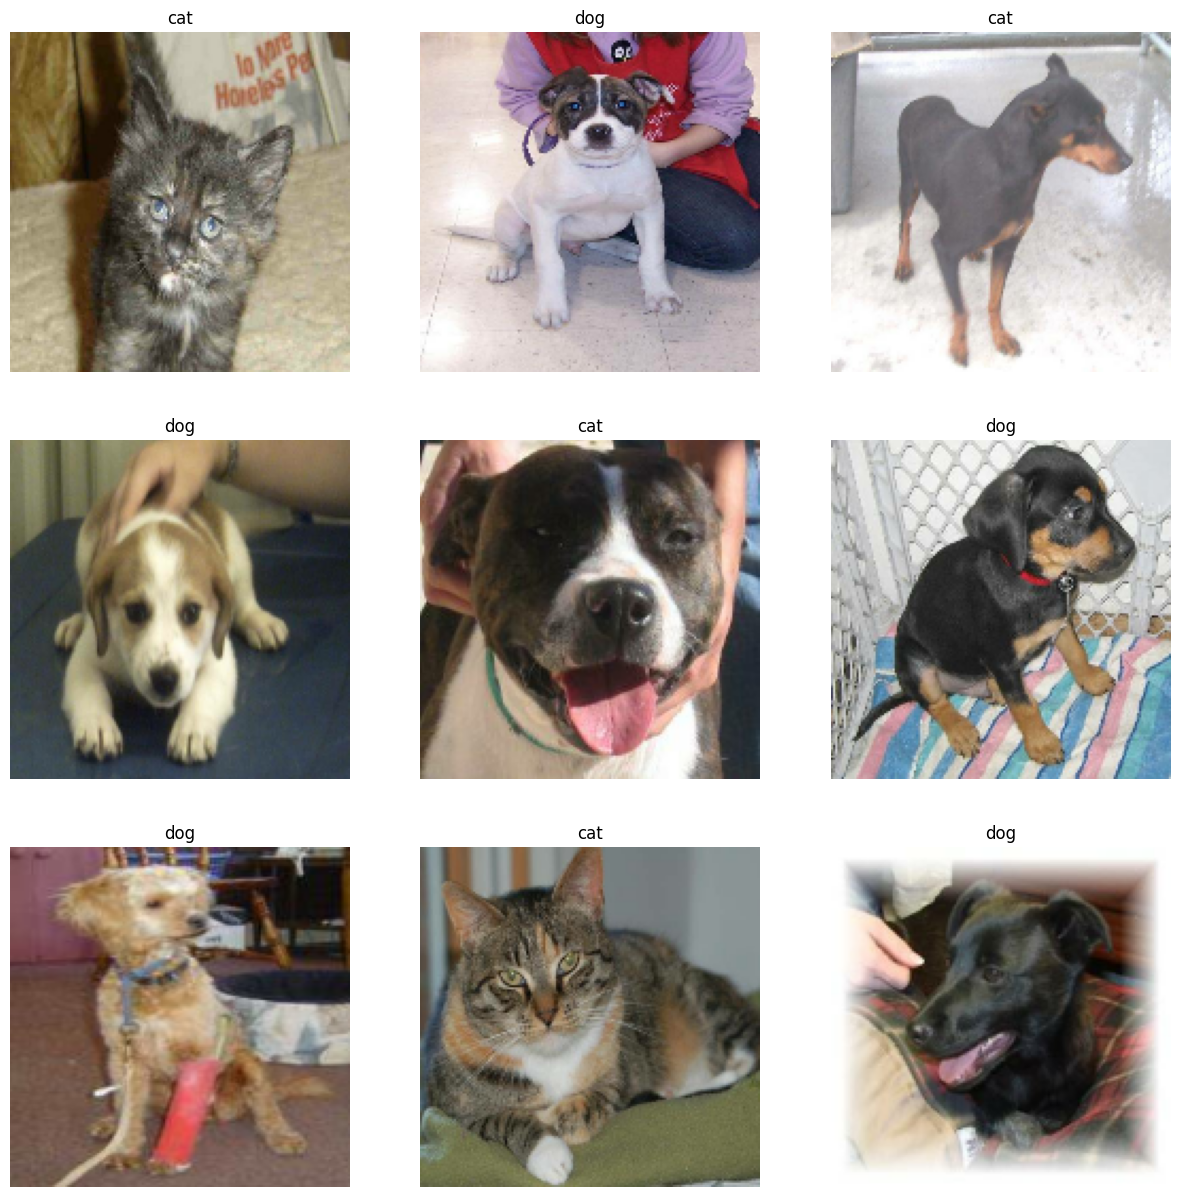

In [22]:
plot_dataset_predictions(dataset_test, model)

Save the model

In [23]:
model.save('model') # path to model

Utilize the model from save

In [24]:
model = tf.keras.models.load_model('model')

Labels:      [0 0 0 0 1 0 0 0 0 1 1 0 1 1 1 1 1 1 0 1 0 1 0 0 0 0 0 0 0 0 1 0]
Predictions: [0 0 1 0 1 0 0 0 1 1 1 0 1 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 1 1 0 0]


<Figure size 640x480 with 0 Axes>

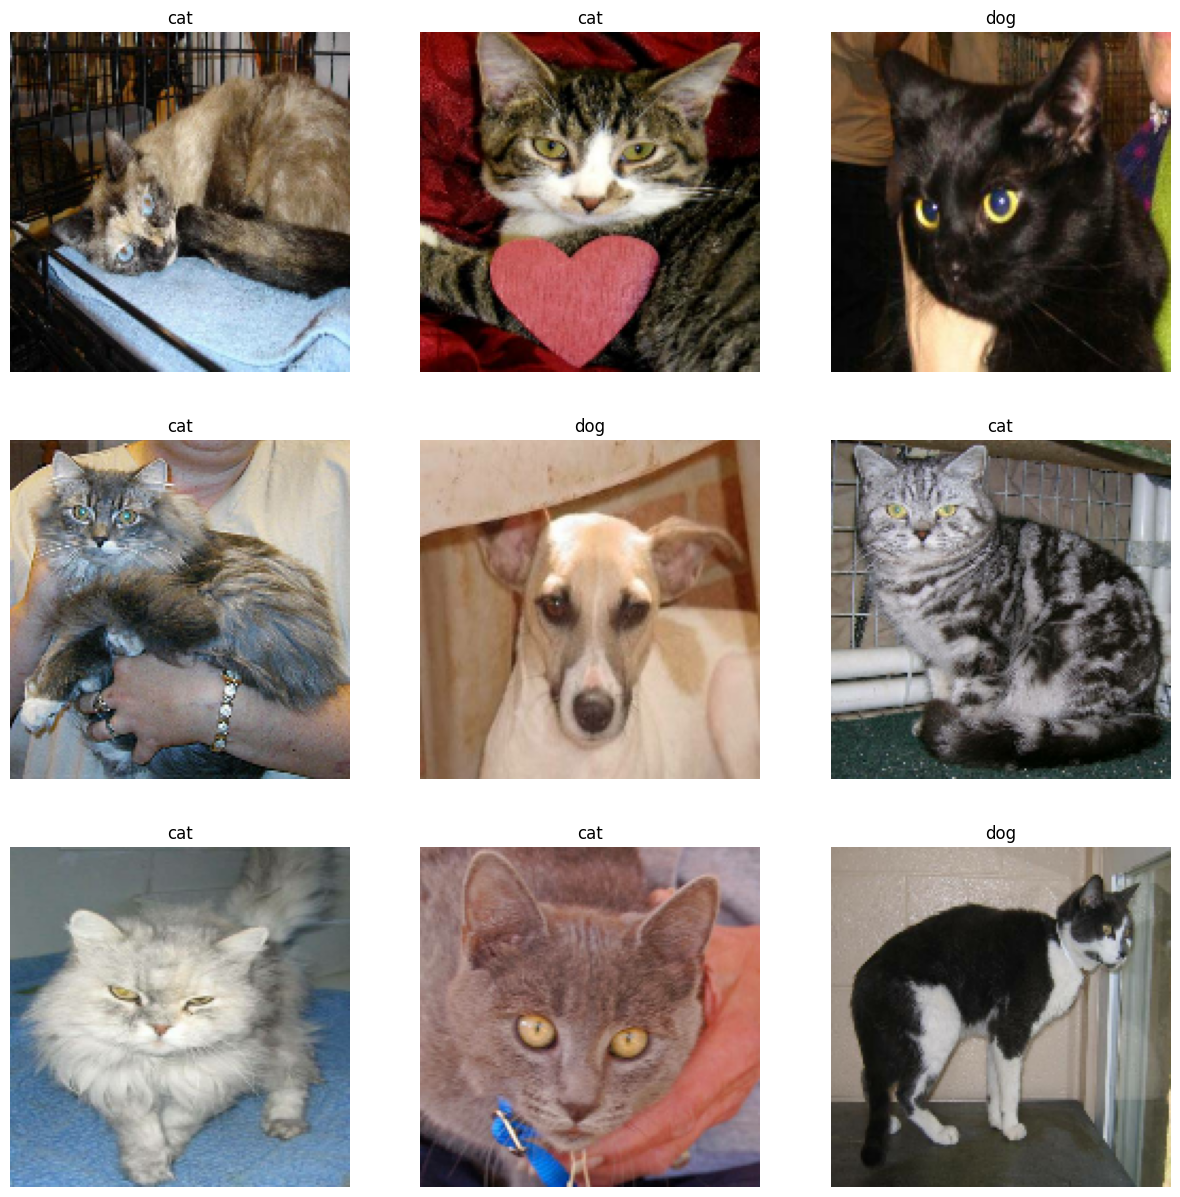

In [25]:
plot_dataset_predictions(dataset_test, model)